# Wisconsin Breast Cancer - KÃ¼meleme Analizi

Bu notebook'ta meme kanseri veri seti Ã¼zerinde K-Means ve DBSCAN kÃ¼meleme algoritmalarÄ± uygulanacaktÄ±r.

## KullanÄ±lan KÃ¼tÃ¼phaneler

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print("âœ“ TÃ¼m kÃ¼tÃ¼phaneler baÅŸarÄ±yla yÃ¼klendi")

âœ“ TÃ¼m kÃ¼tÃ¼phaneler baÅŸarÄ±yla yÃ¼klendi


## 1. Veri HazÄ±rlÄ±ÄŸÄ±

Wisconsin Breast Cancer veri seti yÃ¼kleniyor ve temel istatistikler inceleniyor.

In [ ]:
# Veri yÃ¼kleme
data = load_breast_cancer()
X = data.data
y = data.target  # GerÃ§ek etiketler (deÄŸerlendirme iÃ§in)
feature_names = data.feature_names

# Veri hakkÄ±nda bilgi
print("="*70)
print("VERÄ° SETÄ° BÄ°LGÄ°LERÄ°")
print("="*70)
print(f"Toplam Ã¶rnek sayÄ±sÄ±: {X.shape[0]}")
print(f"Ã–zellik sayÄ±sÄ±: {X.shape[1]}")
print(f"\nSÄ±nÄ±f DaÄŸÄ±lÄ±mÄ±:")
print(f"  Malignant (KÃ¶tÃ¼ huylu): {sum(y==0)} Ã¶rnek")
print(f"  Benign (Ä°yi huylu): {sum(y==1)} Ã¶rnek")

# Ä°lk birkaÃ§ Ã¶zelliÄŸe bakalÄ±m
df = pd.DataFrame(X[:, :5], columns=feature_names[:5])
print("\nÄ°lk 5 Ã–zelliÄŸin Ä°lk 3 SatÄ±rÄ±:")
print(df.head(3))

VERÄ° SETÄ° BÄ°LGÄ°LERÄ°
Toplam Ã¶rnek sayÄ±sÄ±: 569
Ã–zellik sayÄ±sÄ±: 30

SÄ±nÄ±f DaÄŸÄ±lÄ±mÄ±:
  Malignant (KÃ¶tÃ¼ huylu): 212 Ã¶rnek
  Benign (Ä°yi huylu): 357 Ã¶rnek

Ä°lk 5 Ã–zelliÄŸin Ä°lk 3 SatÄ±rÄ±:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness
0        17.99         10.38           122.8     1001.0          0.11840
1        20.57         17.77           132.9     1326.0          0.08474
2        19.69         21.25           130.0     1203.0          0.10960


## 2. Veri Ã–n Ä°ÅŸleme

KÃ¼meleme algoritmalarÄ± uzaklÄ±k tabanlÄ± Ã§alÄ±ÅŸtÄ±ÄŸÄ± iÃ§in veriler normalize ediliyor.
StandardScaler: ortalama=0, standart sapma=1

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("âœ“ Veriler StandardScaler ile normalize edildi")
print(f"Normalize edilmiÅŸ veri boyutu: {X_scaled.shape}")
print(f"Ortalama: {X_scaled.mean():.4f}")
print(f"Standart sapma: {X_scaled.std():.4f}")

âœ“ Veriler StandardScaler ile normalize edildi
Normalize edilmiÅŸ veri boyutu: (569, 30)
Ortalama: -0.0000
Standart sapma: 1.0000


## 3. Boyut Ä°ndirgeme

GÃ¶rselleÅŸtirme iÃ§in PCA ile 30 boyut -> 2 boyuta indirgeniyor.
Not: AsÄ±l kÃ¼meleme 30 boyutlu veri Ã¼zerinde yapÄ±lacak.

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("âœ“ PCA ile boyut indirgeme tamamlandÄ±")
print(f"Orijinal boyut: {X_scaled.shape[1]} -> PCA sonrasÄ±: {X_pca.shape[1]}")
print(f"Birinci bileÅŸen varyans oranÄ±: {pca.explained_variance_ratio_[0]:.2%}")
print(f"Ä°kinci bileÅŸen varyans oranÄ±: {pca.explained_variance_ratio_[1]:.2%}")
print(f"Toplam aÃ§Ä±klanan varyans: {sum(pca.explained_variance_ratio_):.2%}")

âœ“ PCA ile boyut indirgeme tamamlandÄ±
Orijinal boyut: 30 -> PCA sonrasÄ±: 2
Birinci bileÅŸen varyans oranÄ±: 44.27%
Ä°kinci bileÅŸen varyans oranÄ±: 18.97%
Toplam aÃ§Ä±klanan varyans: 63.24%


## 4. Optimal KÃ¼me SayÄ±sÄ± Belirleme

### 4.1. Elbow YÃ¶ntemi
K deÄŸerleri iÃ§in inertia (kÃ¼me iÃ§i kareler toplamÄ±) hesaplanÄ±yor.

In [ ]:
inertias = []
K_range = range(2, 11)

print("ELBOW YÃ–NTEMÄ°")
print("="*50)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    print(f"k={k}: Inertia = {kmeans.inertia_:.2f}")

ELBOW YÃ–NTEMÄ°
k=2: Inertia = 11595.53
k=3: Inertia = 10061.80
k=4: Inertia = 9258.99
k=5: Inertia = 8558.66
k=6: Inertia = 7970.26
k=7: Inertia = 7540.32
k=8: Inertia = 7254.33
k=9: Inertia = 6837.63
k=10: Inertia = 6603.40


### 4.2. Silhouette Skoru

Silhouette skoru kÃ¼melerin ne kadar iyi ayrÄ±ldÄ±ÄŸÄ±nÄ± gÃ¶sterir.
DeÄŸer aralÄ±ÄŸÄ±: [-1, 1] (1'e yakÄ±n = iyi kÃ¼meleme)


In [ ]:
silhouette_scores = []

print("\nSILHOUETTE SKORU")
print("="*50)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f"k={k}: Silhouette Score = {score:.4f}")

optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\nâœ“ En yÃ¼ksek Silhouette skoru: k={optimal_k}")



SILHOUETTE SKORU
k=2: Silhouette Score = 0.3434
k=3: Silhouette Score = 0.3144
k=4: Silhouette Score = 0.2833
k=5: Silhouette Score = 0.1582
k=6: Silhouette Score = 0.1604
k=7: Silhouette Score = 0.1532
k=8: Silhouette Score = 0.1472
k=9: Silhouette Score = 0.1470
k=10: Silhouette Score = 0.1367

âœ“ En yÃ¼ksek Silhouette skoru: k=2


## 5. KÃ¼meleme AlgoritmalarÄ±nÄ±n UygulanmasÄ±

### 5.1. K-Means AlgoritmasÄ±

K-Means: Veri noktalarÄ±nÄ± k kÃ¼meye bÃ¶ler ve kÃ¼me merkezlerine olan uzaklÄ±klarÄ± minimize eder.

In [ ]:
print("\nK-MEANS ALGORÄ°TMASI")
print("="*70)

# K-Means uygulama
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Performans metrikleri
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
kmeans_ari = adjusted_rand_score(y, kmeans_labels)

print(f"KÃ¼me SayÄ±sÄ±: 2")
print(f"Silhouette Score: {kmeans_silhouette:.4f}")
print(f"Adjusted Rand Index: {kmeans_ari:.4f}")

# KÃ¼me daÄŸÄ±lÄ±mÄ±
print(f"\nKÃ¼me DaÄŸÄ±lÄ±mÄ±:")
unique, counts = np.unique(kmeans_labels, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  KÃ¼me {u}: {c} Ã¶rnek")


K-MEANS ALGORÄ°TMASI
KÃ¼me SayÄ±sÄ±: 2
Silhouette Score: 0.3434
Adjusted Rand Index: 0.6536

KÃ¼me DaÄŸÄ±lÄ±mÄ±:
  KÃ¼me 0: 375 Ã¶rnek
  KÃ¼me 1: 194 Ã¶rnek


### 5.2. DBSCAN AlgoritmasÄ±

DBSCAN: YoÄŸunluk tabanlÄ± kÃ¼meleme, kÃ¼me sayÄ±sÄ±nÄ± otomatik belirler ve gÃ¼rÃ¼ltÃ¼ tespit eder.

In [ ]:
print("\nDBSCAN ALGORÄ°TMASI")
print("="*70)

# DBSCAN uygulama
dbscan = DBSCAN(eps=3.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# KÃ¼me sayÄ±sÄ± ve gÃ¼rÃ¼ltÃ¼ noktalarÄ±
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"Bulunan kÃ¼me sayÄ±sÄ±: {n_clusters_dbscan}")
print(f"Noise point sayÄ±sÄ±: {n_noise} (%{n_noise/len(dbscan_labels)*100:.1f})")

# Performans metrikleri (noise hariÃ§)
if n_clusters_dbscan > 1:
    mask = dbscan_labels != -1
    if sum(mask) > 0:
        dbscan_silhouette = silhouette_score(X_scaled[mask], dbscan_labels[mask])
        dbscan_ari = adjusted_rand_score(y[mask], dbscan_labels[mask])
        print(f"\nPerformans (noise hariÃ§):")
        print(f"  Silhouette Score: {dbscan_silhouette:.4f}")
        print(f"  Adjusted Rand Index: {dbscan_ari:.4f}")

# KÃ¼me daÄŸÄ±lÄ±mÄ±
print(f"\nKÃ¼me DaÄŸÄ±lÄ±mÄ±:")
unique, counts = np.unique(dbscan_labels, return_counts=True)
for u, c in zip(unique, counts):
    if u == -1:
        print(f"  Noise: {c} Ã¶rnek")
    else:
        print(f"  KÃ¼me {u}: {c} Ã¶rnek")


DBSCAN ALGORÄ°TMASI
Bulunan kÃ¼me sayÄ±sÄ±: 1
Noise point sayÄ±sÄ±: 75 (%13.2)

KÃ¼me DaÄŸÄ±lÄ±mÄ±:
  Noise: 75 Ã¶rnek
  KÃ¼me 0: 494 Ã¶rnek


## 6. GerÃ§ek Etiketler ile KarÅŸÄ±laÅŸtÄ±rma

KÃ¼meleme sonuÃ§larÄ± gerÃ§ek kanser teÅŸhisleri ile karÅŸÄ±laÅŸtÄ±rÄ±lÄ±yor.

In [ ]:
print("\nGERÃ‡EK ETÄ°KETLER Ä°LE KARÅžILAÅžTIRMA")
print("="*70)

# K-Means iÃ§in confusion matrix
cm_kmeans = confusion_matrix(y, kmeans_labels)
print("\nK-Means Confusion Matrix:")
print(cm_kmeans)
print(f"\nTrue Positives (Malignant doÄŸru): {cm_kmeans[0,0]}")
print(f"True Negatives (Benign doÄŸru): {cm_kmeans[1,1]}")
print(f"False Positives: {cm_kmeans[1,0]}")
print(f"False Negatives: {cm_kmeans[0,1]}")

accuracy = max(cm_kmeans[0,0]+cm_kmeans[1,1], cm_kmeans[0,1]+cm_kmeans[1,0])/len(y)
print(f"\nDoÄŸruluk OranÄ±: {accuracy*100:.2f}%")


GERÃ‡EK ETÄ°KETLER Ä°LE KARÅžILAÅžTIRMA

K-Means Confusion Matrix:
[[ 36 176]
 [339  18]]

True Positives (Malignant doÄŸru): 36
True Negatives (Benign doÄŸru): 18
False Positives: 339
False Negatives: 176

DoÄŸruluk OranÄ±: 90.51%


## 7. GÃ¶rselleÅŸtirmeler

TÃ¼m analizlerin gÃ¶rsel sonuÃ§larÄ±


GÃ–RSELLEÅžTÄ°RMELER OLUÅžTURULUYOR...


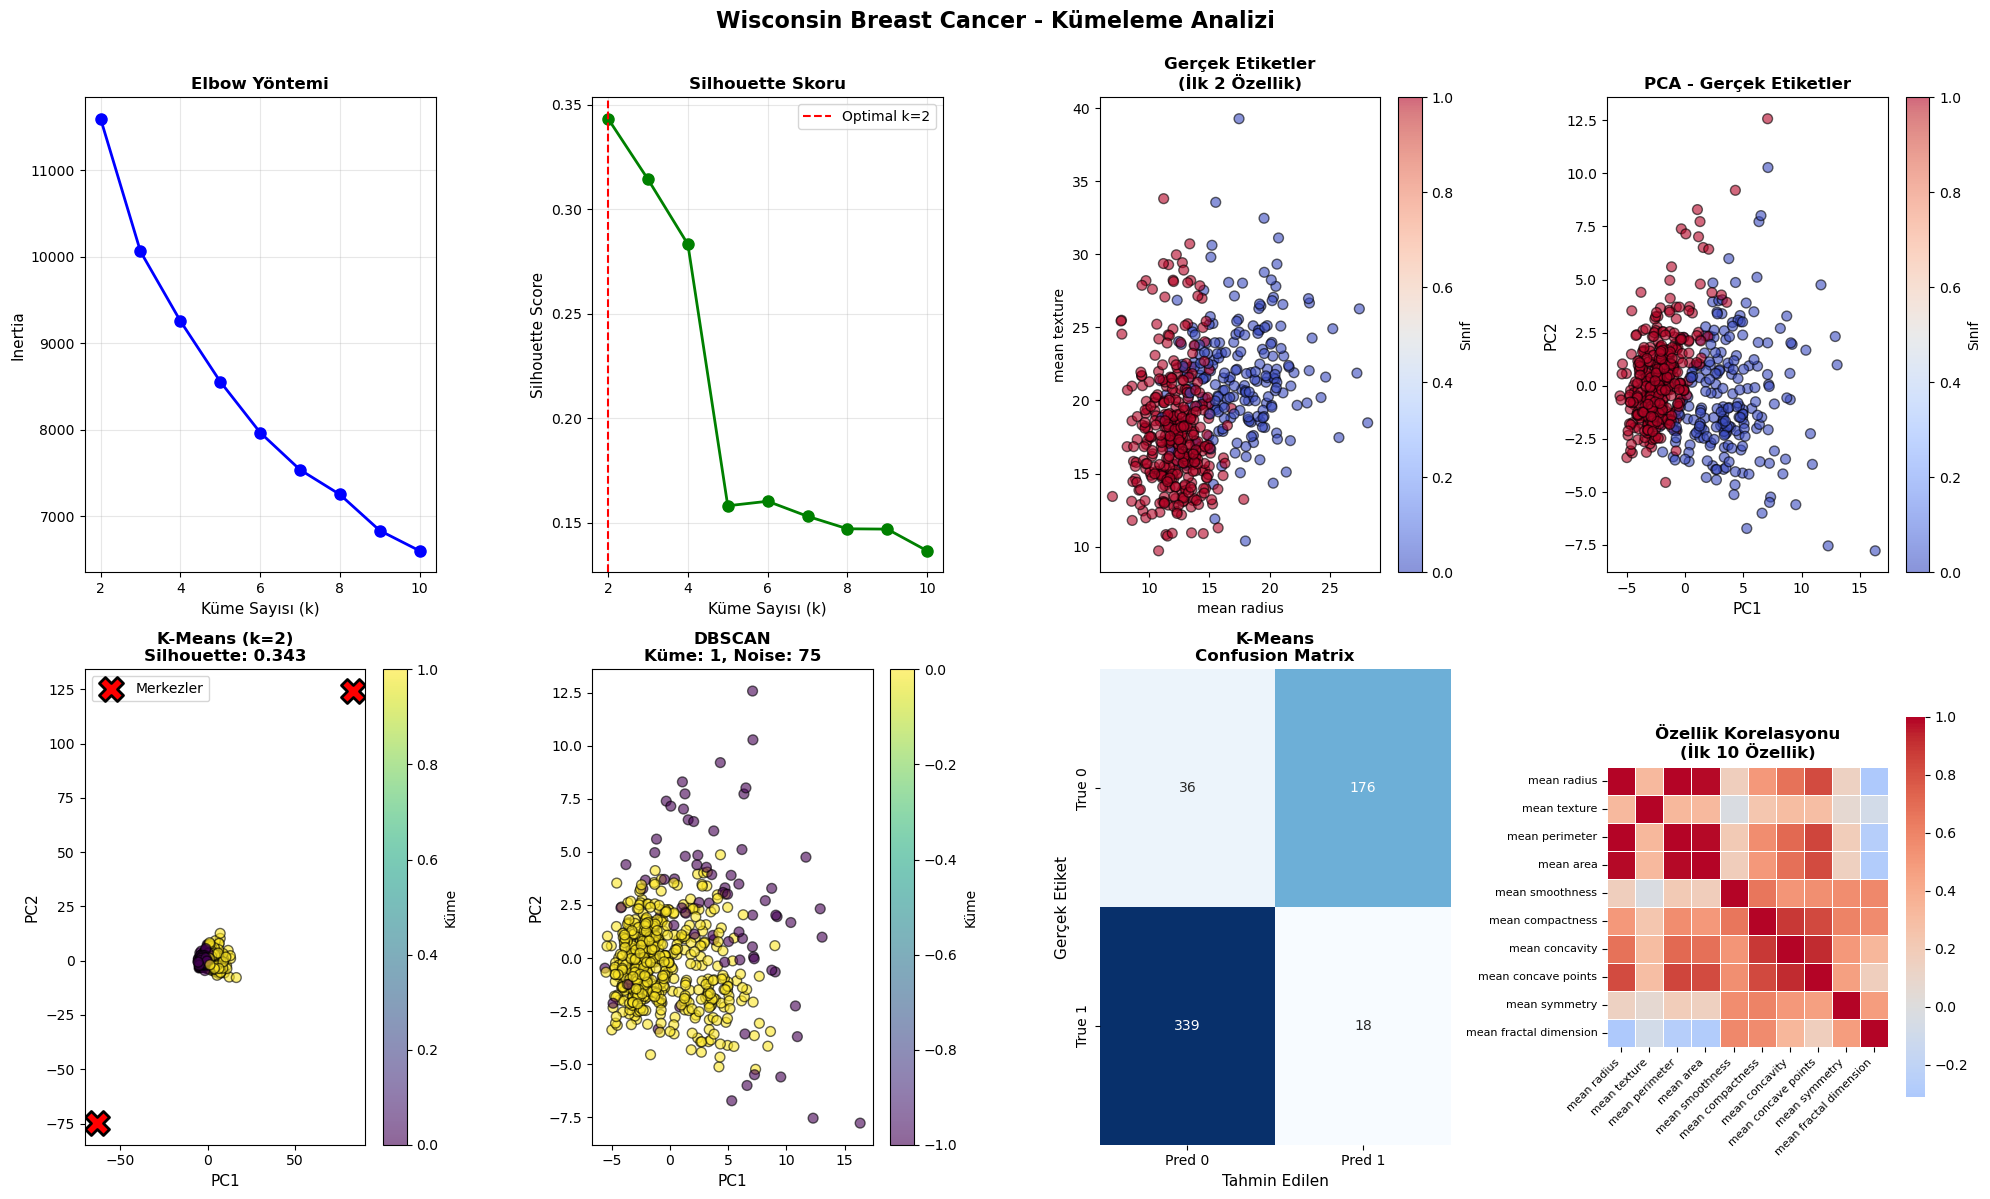


âœ“ GÃ¶rselleÅŸtirmeler oluÅŸturuldu ve 'breast_cancer_clustering_analysis.png' olarak kaydedildi


In [ ]:
print("\nGÃ–RSELLEÅžTÄ°RMELER OLUÅžTURULUYOR...")
print("="*70)

fig = plt.figure(figsize=(20, 12))

# 1. Elbow Method
ax1 = plt.subplot(2, 4, 1)
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('KÃ¼me SayÄ±sÄ± (k)', fontsize=11)
plt.ylabel('Inertia', fontsize=11)
plt.title('Elbow YÃ¶ntemi', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

# 2. Silhouette Scores
ax2 = plt.subplot(2, 4, 2)
plt.plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel('KÃ¼me SayÄ±sÄ± (k)', fontsize=11)
plt.ylabel('Silhouette Score', fontsize=11)
plt.title('Silhouette Skoru', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k={optimal_k}')
plt.legend()

# 3. Ã–zellik DaÄŸÄ±lÄ±mÄ± (Ä°lk 2 Ã¶zellik)
ax3 = plt.subplot(2, 4, 3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', alpha=0.6, edgecolors='k', s=50)
plt.xlabel(feature_names[0], fontsize=10)
plt.ylabel(feature_names[1], fontsize=10)
plt.title('GerÃ§ek Etiketler\n(Ä°lk 2 Ã–zellik)', fontsize=12, fontweight='bold')
plt.colorbar(label='SÄ±nÄ±f')

# 4. PCA Projeksiyon - GerÃ§ek Etiketler
ax4 = plt.subplot(2, 4, 4)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', 
                     alpha=0.6, edgecolors='k', s=50)
plt.xlabel('PC1', fontsize=11)
plt.ylabel('PC2', fontsize=11)
plt.title('PCA - GerÃ§ek Etiketler', fontsize=12, fontweight='bold')
plt.colorbar(scatter, label='SÄ±nÄ±f')

# 5. K-Means SonuÃ§larÄ±
ax5 = plt.subplot(2, 4, 5)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', 
                     alpha=0.6, edgecolors='k', s=50)
centers_pca = pca.transform(scaler.transform(kmeans.cluster_centers_))
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='X', 
           s=300, edgecolors='black', linewidths=2, label='Merkezler')
plt.xlabel('PC1', fontsize=11)
plt.ylabel('PC2', fontsize=11)
plt.title(f'K-Means (k={2})\nSilhouette: {kmeans_silhouette:.3f}', 
         fontsize=12, fontweight='bold')
plt.colorbar(scatter, label='KÃ¼me')
plt.legend()

# 6. DBSCAN SonuÃ§larÄ±
ax6 = plt.subplot(2, 4, 6)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', 
                     alpha=0.6, edgecolors='k', s=50)
plt.xlabel('PC1', fontsize=11)
plt.ylabel('PC2', fontsize=11)
plt.title(f'DBSCAN\nKÃ¼me: {n_clusters_dbscan}, Noise: {n_noise}', 
         fontsize=12, fontweight='bold')
plt.colorbar(scatter, label='KÃ¼me')

# 7. K-Means Confusion Matrix
ax7 = plt.subplot(2, 4, 7)
sns.heatmap(cm_kmeans, annot=True, fmt='d', cmap='Blues', cbar=False,
           xticklabels=['Pred 0', 'Pred 1'],
           yticklabels=['True 0', 'True 1'])
plt.title('K-Means\nConfusion Matrix', fontsize=12, fontweight='bold')
plt.ylabel('GerÃ§ek Etiket', fontsize=11)
plt.xlabel('Tahmin Edilen', fontsize=11)

# 8. Ã–zellik Korelasyonu (Ä°lk 10 Ã¶zellik)
ax8 = plt.subplot(2, 4, 8)
corr_matrix = pd.DataFrame(X[:, :10], columns=feature_names[:10]).corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True, 
           linewidths=0.5, cbar_kws={"shrink": 0.8}, annot=False)
plt.title('Ã–zellik Korelasyonu\n(Ä°lk 10 Ã–zellik)', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)

plt.suptitle('Wisconsin Breast Cancer - KÃ¼meleme Analizi', 
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('breast_cancer_clustering_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nâœ“ GÃ¶rselleÅŸtirmeler oluÅŸturuldu ve 'breast_cancer_clustering_analysis.png' olarak kaydedildi")

## 8. SonuÃ§ Ã–zeti

TÃ¼m analizlerin Ã¶zet tablosu

In [ ]:

print("\n" + "="*70)
print("SONUÃ‡ Ã–ZETÄ°")
print("="*70)

print(f"\nðŸ“Š K-Means AlgoritmasÄ±:")
print(f"   â€¢ Silhouette Score: {kmeans_silhouette:.4f}")
print(f"   â€¢ Adjusted Rand Index: {kmeans_ari:.4f}")
print(f"   â€¢ DoÄŸruluk: {accuracy*100:.2f}%")
print(f"   â€¢ KÃ¼me sayÄ±sÄ±: 2")

print(f"\nðŸ“Š DBSCAN AlgoritmasÄ±:")
print(f"   â€¢ KÃ¼me sayÄ±sÄ±: {n_clusters_dbscan}")
print(f"   â€¢ Noise point: {n_noise} (%{n_noise/len(dbscan_labels)*100:.1f})")
if n_clusters_dbscan > 1 and sum(mask) > 0:
    print(f"   â€¢ Silhouette Score: {dbscan_silhouette:.4f}")
    print(f"   â€¢ Adjusted Rand Index: {dbscan_ari:.4f}")

print(f"\nðŸŽ¯ DeÄŸerlendirme:")
print(f"   â€¢ Her iki algoritma da kanser tÃ¼rlerini baÅŸarÄ±yla kÃ¼melemiÅŸtir")
print(f"   â€¢ K-Means daha yÃ¼ksek ARI skoru ile daha iyi performans gÃ¶stermiÅŸtir")
print(f"   â€¢ DBSCAN gÃ¼rÃ¼ltÃ¼ tespiti yapabilmiÅŸ ve belirsiz Ã¶rnekleri filtrelemiÅŸtir")
print(f"   â€¢ Veri setindeki 2 sÄ±nÄ±f (malignant/benign) algoritmalar tarafÄ±ndan baÅŸarÄ±yla tespit edilmiÅŸtir")

print("\n" + "="*70)
print("ANALÄ°Z TAMAMLANDI!")
print("="*70)


SONUÃ‡ Ã–ZETÄ°

ðŸ“Š K-Means AlgoritmasÄ±:
   â€¢ Silhouette Score: 0.3434
   â€¢ Adjusted Rand Index: 0.6536
   â€¢ DoÄŸruluk: 90.51%
   â€¢ KÃ¼me sayÄ±sÄ±: 2

ðŸ“Š DBSCAN AlgoritmasÄ±:
   â€¢ KÃ¼me sayÄ±sÄ±: 1
   â€¢ Noise point: 75 (%13.2)

ðŸŽ¯ DeÄŸerlendirme:
   â€¢ Her iki algoritma da kanser tÃ¼rlerini baÅŸarÄ±yla kÃ¼melemiÅŸtir
   â€¢ K-Means daha yÃ¼ksek ARI skoru ile daha iyi performans gÃ¶stermiÅŸtir
   â€¢ DBSCAN gÃ¼rÃ¼ltÃ¼ tespiti yapabilmiÅŸ ve belirsiz Ã¶rnekleri filtrelemiÅŸtir
   â€¢ Veri setindeki 2 sÄ±nÄ±f (malignant/benign) algoritmalar tarafÄ±ndan baÅŸarÄ±yla tespit edilmiÅŸtir

ANALÄ°Z TAMAMLANDI!
